In [1]:
# various import statements
import os
import inspect
import seaborn
import matplotlib
import matplotlib.pyplot as plt
import torch
import scanpy as sc
import pyro
import cuml

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print("GPU is available")
    print("Number of GPUs:", torch.cuda.device_count())
    print("GPU Name:", torch.cuda.get_device_name(0))
else:
    print("GPU is not available")
    
import random

import sys
import antipode
from antipode.antipode_model import *
import antipode.model_functions
from antipode.model_functions import *
import antipode.model_distributions
from antipode.model_distributions import *
import antipode.model_modules
from antipode.model_modules import *
import antipode.train_utils
from antipode.train_utils import *
import antipode.plotting
from antipode.plotting import *
from antipode.antipode_mixins import AntipodeTrainingMixin, AntipodeSaveLoadMixin
import scvi
import os
import scanpy as sc
sc.settings.figdir=os.path.expanduser('~/WbFigures/JorstadAllAnalysis')
sc._settings.settings._vector_friendly=True


/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GPU is available
Number of GPUs: 1
GPU Name: Tesla V100-SXM2-32GB


In [2]:
model_tag='1.9.1.8.5_JorstadAll_final_noQ_INP'
out_path=os.path.join('/home/matthew.schmitz/Matthew/models/',model_tag)
model_path='/home/matthew.schmitz/Matthew/models/'+model_tag

adata = antipode.anndata_utils.read_h5ad_backed_selective(os.path.expanduser('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/cortex_data/jorstad_merge_all.h5ad'),
    mode='r', selected_keys=['batch','organism','UMIs','var','uns'])

adata.uns['species_colors']=['blue','red','green','yellow','orange','cyan','magenta','teal','goldenrod','purple','maroon','pink','violet','black','grey','beige']
batch_key='batch'
discov_key='organism'
layer_key='UMIs'

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [4]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="UMIs",
    batch_key=batch_key,
    categorical_covariate_keys=[discov_key],
)

model = scvi.model.SCVI(adata, 
                        dispersion="gene-batch", 
                        n_hidden=128, 
                        n_latent=64, 
                        n_layers=3)
model.train(max_epochs=100)

## Save model
model.save(dir_path="/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/models/JorstadSCVI",overwrite=True)

## Extract integrated space
adata.obsm["X_scVI"] = model.get_latent_representation()

import cuml
umap = cuml.UMAP(n_neighbors = 40,min_dist=0.2,spread=1,metric='manhattan')
adata.obsm["X_umap_scVI"] =umap.fit_transform(adata.obsm['X_scVI'])
adata.obsm["X_umap_scVI"] = antipode.plotting.clip_latent_dimensions(adata.obsm["X_umap_scVI"],0.1)


/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3.12 /home/matthew.schmitz/Matthew/utils/miniforge3/e ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3.12 /home/matthew.schmitz/Matthew/utils/miniforge3/e ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 100/100: 100%|██████████| 100/100 [5:08:46<00:00, 182.24s/it, v_num=1, train_loss_step=2.26e+4, train_loss_epoch=2.21e+4]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [5:08:46<00:00, 185.27s/it, v_num=1, train_loss_step=2.26e+4, train_loss_epoch=2.21e+4]


In [22]:
obs = antipode.anndata_utils.read_h5ad_backed_selective(os.path.expanduser('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/cortex_data/jorstad_merge_all.h5ad'),
    mode='r', selected_keys=['obs'])

ap = antipode.anndata_utils.read_h5ad_backed_selective(os.path.expanduser('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/models/1.9.1.8.5_JorstadAll_final_noQ_INP/p3_adata.h5ad'),
    mode='r', selected_keys=['antipode_cluster','X_antipode','X_antipode_umap'])
adata.obs['antipode_cluster'] = ap.obs['antipode_cluster']

for c in set(obs.obs.columns)-set(adata.obs.columns):
    adata.obs[c] = obs.obs[c]

adata.obsm['X_antipode'] = ap.obsm['X_antipode']
umap = cuml.UMAP(n_neighbors = 40,min_dist=0.2,spread=1,metric='manhattan')
adata.obsm["X_antipode_umap"] =umap.fit_transform(adata.obsm['X_antipode'])
adata.obsm["X_antipode_umap"] = antipode.plotting.clip_latent_dimensions(adata.obsm["X_antipode_umap"],0.1)



/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


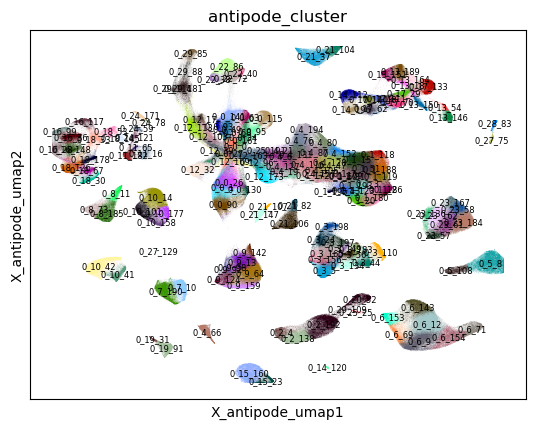

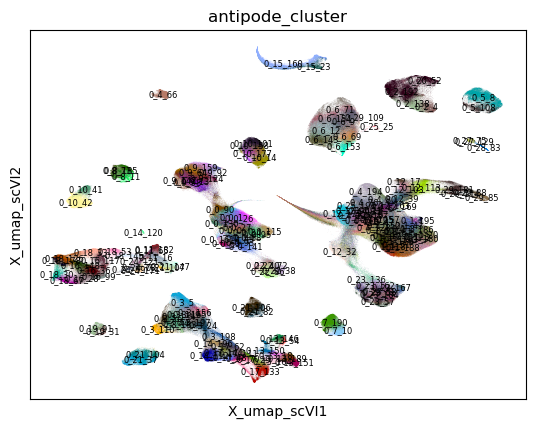

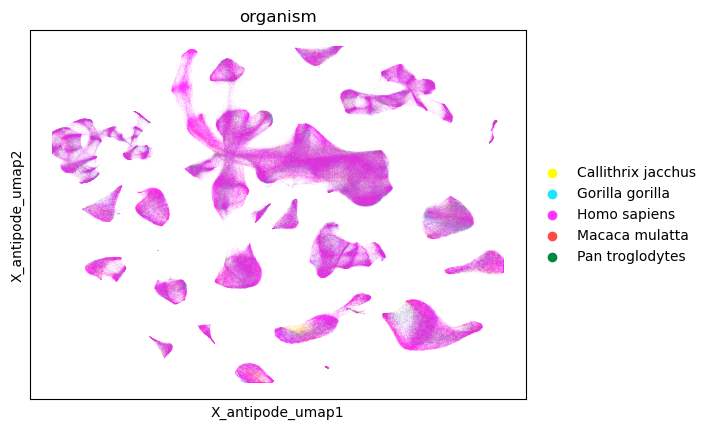

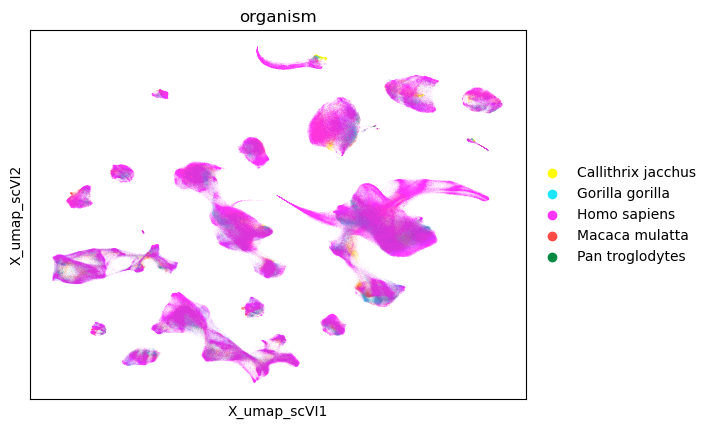

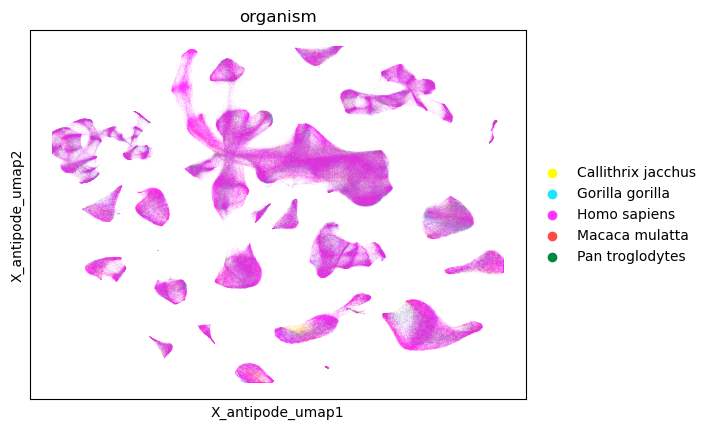

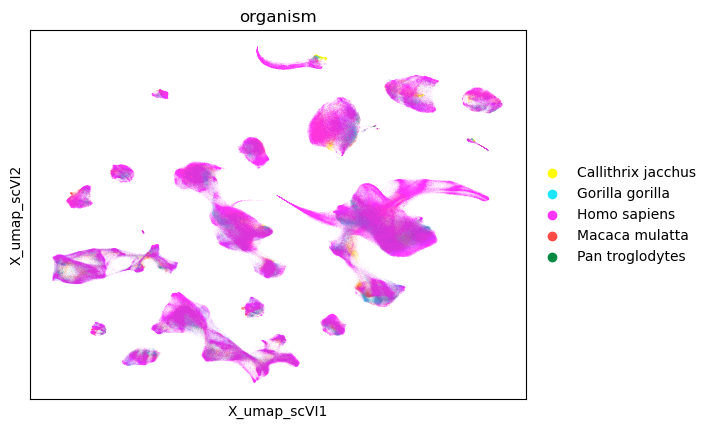

In [38]:
sc.pl.embedding(
    adata,
    basis='X_antipode_umap',
    color=["antipode_cluster"],legend_fontsize=6,legend_fontweight='normal',#,"kmeans"
    legend_loc='on data',palette=sc.pl.palettes.godsnot_102,save=f'_antipode_cluster.pdf'
)
sc.pl.embedding(
    adata,
    basis="X_umap_scVI",
    color=["antipode_cluster"],legend_fontsize=6,legend_fontweight='normal',#,"kmeans"
    legend_loc='on data',palette=sc.pl.palettes.godsnot_102,save=f'_antipode_cluster.pdf'
)

sc.pl.embedding(
    adata,
    basis='X_antipode_umap',
    palette=sc.pl.palettes.godsnot_102,
    color=[discov_key],save=f'tissue.pdf'
)
sc.pl.embedding(
    adata,
    basis="X_umap_scVI",
    palette=sc.pl.palettes.godsnot_102,
    color=[discov_key],save=f'tissue.pdf'
)

sc.pl.embedding(
    adata,
    basis='X_antipode_umap',
    palette=sc.pl.palettes.godsnot_102,
    color=[discov_key],save=f'{discov_key}.pdf'
)
sc.pl.embedding(
    adata,
    basis="X_umap_scVI",
    palette=sc.pl.palettes.godsnot_102,
    color=[discov_key],save=f'{discov_key}.pdf'
)

In [ ]:
# adata.write_h5ad(os.path.join(model_path,'analysis_inprogress_scvi.h5ad'))

In [33]:
np.savetxt(os.path.join(model_path,f"X_scVI.csv"), adata.obsm['X_scVI'], delimiter=",")
np.savetxt(os.path.join(model_path,f"X_umap_scVI.csv"), adata.obsm['X_umap_scVI'], delimiter=",")
np.savetxt(os.path.join(model_path,f"X_antipode_umap.csv"), adata.obsm['X_antipode_umap'], delimiter=",")